In [5]:
# Cell 1: Import libraries
import numpy as np
import cv2
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from skimage.feature import local_binary_pattern

In [11]:
# Cell 2: Path dataset + list classes
train_path = '/kaggle/input/biji-kopi/train'
valid_path = '/kaggle/input/biji-kopi/valid'
test_path = '/kaggle/input/biji-kopi/test'

classes = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
print(f"Total classes: {len(classes)}")

Total classes: 54


In [13]:
# Cell 3: Preprocessing (resize & normalize)
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

In [14]:
# Cell 4: Ekstraksi fitur (HSV hist + LBP)
def extract_features(img):
    img_uint8 = (img * 255).astype(np.uint8)
    hsv = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2HSV)
    
    h_hist = cv2.calcHist([hsv], [0], None, [256], [0, 256]).flatten()
    s_hist = cv2.calcHist([hsv], [1], None, [256], [0, 256]).flatten()
    v_hist = cv2.calcHist([hsv], [2], None, [256], [0, 256]).flatten()
    
    v_channel = hsv[:, :, 2]
    radius = 2
    points = 8 * radius
    lbp = local_binary_pattern(v_channel, points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=256, range=(0, 256))
    
    feature = np.concatenate([h_hist, s_hist, v_hist, lbp_hist])
    return feature

def load_and_extract(data_path, classes):
    features = []
    labels = []
    for idx, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if not os.path.isfile(img_path):
                continue
            img = preprocess_image(img_path)
            feat = extract_features(img)
            features.append(feat)
            labels.append(idx)
    return np.array(features), np.array(labels)

In [15]:
# Cell 5: Ekstraksi fitur TRAIN
print("Extracting TRAIN features...")
X_train, y_train = load_and_extract(train_path, classes)
print(f"Train shape: {X_train.shape}")

Extracting TRAIN features...
Train shape: (7236, 1024)


In [16]:
# Cell 6: Ekstraksi fitur VALID
print("Extracting VALID features...")
X_valid, y_valid = load_and_extract(valid_path, classes)
print(f"Valid shape: {X_valid.shape}")

Extracting VALID features...
Valid shape: (918, 1024)


In [17]:
# Cell 7: Ekstraksi fitur TEST
print("Extracting TEST features...")
X_test, y_test = load_and_extract(test_path, classes)
print(f"Test shape: {X_test.shape}")

Extracting TEST features...
Test shape: (918, 1024)


In [18]:
# Cell 8: Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)
print("Scaling completed")

Scaling completed


In [19]:
# Cell 9: Train K-NN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_scaled, y_train)
print("K-NN training completed")

K-NN training completed


In [20]:
# Cell 10: Evaluasi model
y_valid_pred = knn.predict(X_valid_scaled)
y_test_pred = knn.predict(X_test_scaled)

valid_acc = accuracy_score(y_valid, y_valid_pred)
test_acc = accuracy_score(y_test, y_test_pred)
macro_f1 = f1_score(y_test, y_test_pred, average='macro')
cm = confusion_matrix(y_test, y_test_pred)

print(f"Valid Accuracy: {valid_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Confusion Matrix Shape: {cm.shape}")

Valid Accuracy: 0.4956
Test Accuracy: 0.4880
Macro F1: 0.4804
Confusion Matrix Shape: (54, 54)


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np

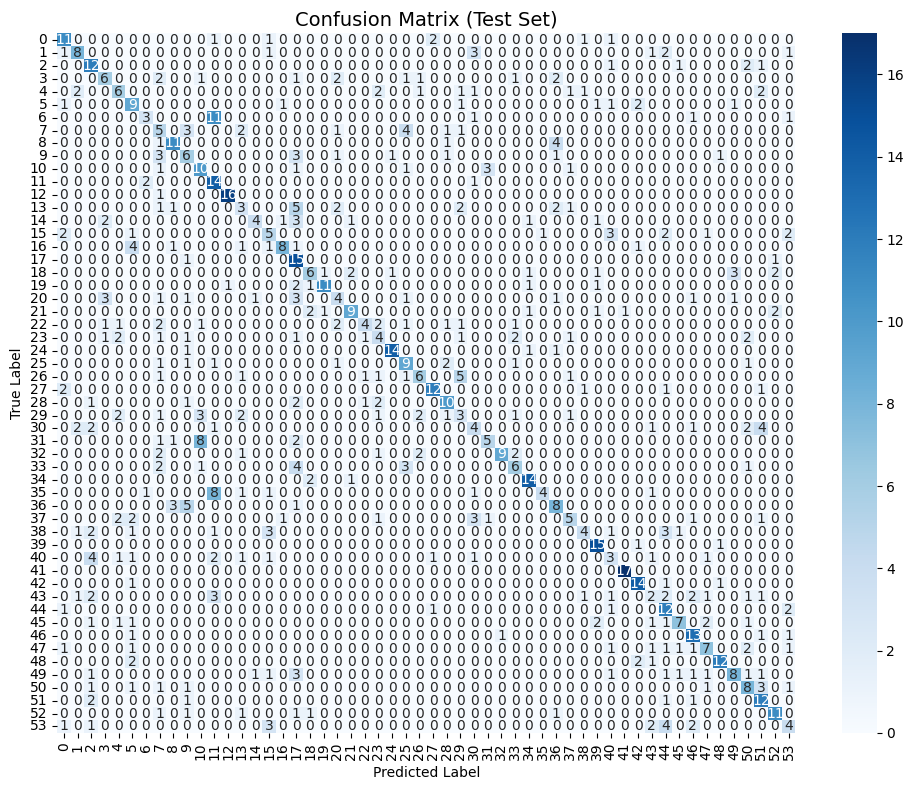

In [24]:
# Visualisasi Confusion Matrix dengan seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), 
            yticklabels=np.unique(y_test))
plt.title('Confusion Matrix (Test Set)', fontsize=14)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()